# 左手法

左手法とは，
- 常に壁に左手をつけた状態で進んでいけば，いつかは必ずゴールに辿り着ける 

といった，迷路を探索する時に使われる手法である．

<br>

# 必要なライブラリのインポート

In [8]:
import numpy as np
import random
from sympy.geometry import *
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
%matplotlib inline

<br>

# ランダムな迷路の作成
左手法と直接的な関係はないのでスキップしてOK（実行はしてください）

In [9]:
def create_outer_wall(maze):
    """
    迷路の四方に壁を生成

    Parameters
    ----------
    maze: numpy.ndarray
        迷路

    Returns
    -------
    maze: numpy.ndarray
        壁を生成した後の迷路
    """

    maze_h = maze.shape[0]
    maze_w = maze.shape[1]
    for i in range(maze_w):
        maze[0][i] = 1
        maze[maze_h-1][i] = 1
    for i in range(maze_h):
        maze[i][maze_w-1] = 1
        maze[i][0] = 1
    return maze
    
def create_pillar(maze):
    """
    迷路内に柱を作る

    Parameters
    ----------
    maze: numpy.ndarray
        迷路

    Returns
    -------
    maze: numpy.ndarray
        柱を生成した後の迷路
    """
    maze_h = maze.shape[0]
    maze_w = maze.shape[1]
    for y in range(2, maze_h - 2, 2):    # range()は第三引数を2を指定し、ステップ機能で1マス飛ばししている
        for x in range(2, maze_h - 2, 2):
            maze[y][x] = 1
    return maze

def create_random_obs(maze):
    """
    迷路内にランダムな壁を作成する

    Parameters
    ----------
    maze: numpy.ndarray
        迷路

    Returns
    -------
    maze: numpy.ndarray
        ランダムな壁を生成した後の迷路
    """
    # 柱から伸ばす壁に利用する値を定義
    # [上, 右, 下, 左]
    XP = [0, 1, 0, -1]
    YP = [-1, 0, 1, 0]
    maze_h = maze.shape[0]
    maze_w = maze.shape[1]    
    # 各柱から壁を伸ばす
    for y in range(2, maze_h - 2, 2):
        for x in range(2, maze_w - 2, 2):
            while True:
                d = random.randint(0, 3)            # 変数dに柱から伸ばす方向を0~3で指定
                if x > 2:                           # 2列目以降なら0~2（左を示す3を含めない）で左に伸ばさない
                    d = random.randint(0, 2)
                
                if maze[y + YP[d]][x + XP[d]] == 1: # dの値が既に壁が作られた場所であればやり直し
                    continue

                # 柱から伸ばす壁を示す値（変数d）を、定数YP、XPの添字に使い壁を伸ばすマス目を指定
                # そのマス目を表すmaze[]に壁有りを示す1を代入
                maze[y + YP[d]][x + XP[d]] = 1
                break
    return maze
    
def set_random_start(maze):
    """
    迷路内の（壁以外の）ランダムな位置にスタート地点を設定

    Parameters
    ----------
    maze: numpy.ndarray
        迷路

    Returns
    -------
    start: list[int]
        スタート地点の座標[x.y]
    """
    # continue until  start position is on the not wall.
    start = [0, 0]
    maze_h = maze.shape[0]
    maze_w = maze.shape[1]    
    while True:
        start[0] = random.randint(0, maze_w-1) # start x
        start[1] = random.randint(0, maze_h-1) # start y
        if maze[start[1]][start[0]] == 0: # self.bofy[y][x]
            break
    return start
    
def set_random_goal(maze):
    """
    迷路内の（壁以外の）ランダムな位置にゴール地点を設定

    Parameters
    ----------
    maze: numpy.ndarray
        迷路

    Returns
    -------
    start: list[int]
        ゴール地点の座標[x.y]
    """
    maze_h = maze.shape[0]
    maze_w = maze.shape[1]    
    # continue until  start position is on the not wall.
    goal = [0, 0]
    while True:
        goal[0] = random.randint(0, maze_w-1) # start x
        goal[1] = random.randint(0, maze_h-1) # start y
        if maze[goal[1]][goal[0]] == 0: # self.bofy[y][x]
            break
    return goal

def plot_start_and_goal(ax, start, goal):
    """
    迷路のスタート地点とゴール地点を描画

    Parameters
    ----------
    ax: AxisImage
        描画する画像
    start: list[int]
        スタート地点
    goal: list[int]
        ゴール地点
    """       
    ax.plot(start[0], start[1], "o", color="red", markersize=10)
    ax.plot(goal[0], goal[1], "o", color="green", markersize=10)

def plot_agent(ax, x, y, theta):
    """
    エージェント（移動ロボット）を描画

    Parameters
    ----------
    x: int
        エージェントの現在位置（x座標）
    y: list[int]
        エージェントの現在位置（y座標）
    theta: int
        エージェントの現在向いている方向（deg）
    """   
    r = 0.5
    circle = plt.Circle((x, y), r, ec='b', fill=False)
    ax.add_artist(circle)
    rad = math.radians(theta)
    rx = r*math.cos(rad)
    ry = r*math.sin(rad)
    s0 = Segment(Point(x, y),Point(x+rx, y-ry))
    segments = [s0]
    for i,s in enumerate(segments) :
        ax.plot([s.p1.x, s.p2.x], [s.p1.y, s.p2.y], color='b')

# https://www.sojudo.net/programming/gamealgorithm/pygame_createmaze


<br>

# エージェントの向きを確認
エージェントの「前，左右」の座標を取得する．  
この際，下図のようにエージェントの向きによって「前，左右」の座標が変わることに注意．

In [ ]:
def calc_direction(maze, x, y, theta):
    """
    エージェント（移動ロボット）の向きを確認して，「前，左右」の座標を取得

    Parameters
    ----------
    maze: numpy.ndarray
        迷路
    x : int
        エージェントの現在位置（x座標）
    y : int
        エージェントの現在位置（y座標）
    theta : int
        エージェントの現在角度（deg）

    Returns
    -------
    front_state: int
        エージェントの前方の壁の有無
    right_state: int
        エージェントの右の壁の有無
    left_state: int
        エージェントの左の壁の有無
    """    

    # エージェントが上を向いている時の前と左右の座標を取得
    if math.sin(math.radians(theta)) == 1:
        front_state = maze[y-1][x]
        right_state = maze[y][x+1]
        left_state = maze[y][x-1]

    # エージェントが右を向いている時の前と左右の座標を取得
    elif math.cos(math.radians(theta)) == 1:
        front_state = maze[y][x+1]
        right_state = maze[y+1][x]
        left_state = maze[y-1][x]

    # エージェントが左を向いている時の前と左右の座標を取得
    elif math.cos(math.radians(theta)) == -1:
        front_state = maze[y][x-1]
        right_state = maze[y-1][x]
        left_state = maze[y+1][x]

    # エージェントが下を向いている時の前と左右の座標を取得
    elif  math.sin(math.radians(theta)) == -1:
        front_state = maze[y+1][x]
        right_state = maze[y][x-1]
        left_state = maze[y][x+1]

    return front_state, right_state, left_state

<br>

# 左手法の実装
---

**ここがメイン！**  

---

左手法は，下図のように
- 「エージェントの前と左右の壁の有無」を調べながら，次に進む方向を決定する

ことで，実装可能である．


In [10]:
"""
numpyの配列の場合
1. array[y][x]
2. 原点が左上のため，y軸は下方向がプラス  
なことに注意 
"""

def left_hand_method(maze, start, goal, max_loop=1000, real_time_animation=True):
    """
    左手法を実行

    Parameters
    ----------
    maze: numpy.ndarray
        迷路
    start : list[int]
        スタート地点 (x, y)
    goal : list[int]
        ゴール地点 (x,y)
    max_loop : int
        繰り返し回数（繰り返し回数を超えてたら，ゴールが見つかっていなくても強制終了）
    real_time_animation=True : bool
        探索過程を逐次的に表示するかどうか
        

    Returns
    -------
    xs: list[int]
        スタートからゴールに至るまでの座標（x方向）
    ys: list[int]
        スタートからゴールに至るまでの座標（y方向）
    thetas: list[int]
        スタートからゴールに至るまでの角度（deg）
    """    
    x = start[0]; y = start[1]; theta = 0 # エージェントのスタート位置，角度を設定
    BLANK = 0; WALL = 1 # エージェントが走れる位置：0, エージェントが走れない位置（壁）：1
    xs = []; ys = []; thetas = [] # 経路保存用
    xs.append(start[0]); ys.append(start[1]); thetas.append(theta)

    ###  ここから左手法のメイン ################################
    for loop_num in range(max_loop):

        # エージェントの前と左右の，壁の有無を確認
        front_state, right_state, left_state = calc_direction(maze, x, y, theta)

        # 左回転して前進
        if (right_state==BLANK and left_state==BLANK and front_state == BLANK) or \
        (right_state==WALL and left_state==BLANK and front_state == BLANK) or \
        (right_state==BLANK and left_state==BLANK and front_state == WALL) or \
        (right_state==WALL and left_state==BLANK and front_state == WALL):
            theta += 90
            theta = theta%360
            dx = 1*math.cos(math.radians(theta))
            dy = 1*math.sin(math.radians(theta))
            x += int(dx)
            y -= int(dy)
        
        #　前進
        if (right_state==BLANK and left_state==WALL and front_state == BLANK) or\
        (right_state==WALL and left_state==WALL and front_state == BLANK):
            dx = 1*math.cos(math.radians(theta))
            dy = 1*math.sin(math.radians(theta))
            x += int(dx)
            y -= int(dy)

        # 右回転して前進
        if (right_state==BLANK and left_state==WALL and front_state == WALL):
            theta -= 90
            theta = theta%360
            dx = 1*math.cos(math.radians(theta))
            dy = 1*math.sin(math.radians(theta))
            x += int(dx)
            y -= int(dy)

        # Uターンして前進
        if (right_state==WALL and left_state==WALL and front_state == WALL):
            theta -= 180
            theta = theta%360
            dx = 1*math.cos(math.radians(theta))
            dy = 1*math.sin(math.radians(theta))
            x += int(dx)
            y -= int(dy)
        ############## ここまで左手法のメイン #################################
        
        # 探索の結果を保存
        thetas.append(theta)
        xs.append(x)
        ys.append(y)
        
        ########### plot #############
        if real_time_animation == True:
            fig = plt.figure()
            ax1 = fig.add_subplot()
            plot_start_and_goal(ax1, start, goal)
            plot_agent(ax1, x, y, theta)
            ax1.imshow(maze, cmap="binary")
            plt.pause(0.01)
        #####################################

        # エージェントがゴール地点に到着したら終了
        if x == goal[0] and y == goal[1]:
            print('goal')
            fig = plt.figure()
            ax1 = fig.add_subplot()
            plot_start_and_goal(ax1, start, goal)
            plot_agent(ax1, x, y, theta)
            ax1.imshow(maze, cmap="binary")
            break

        # max_loop回，繰り返してもゴールに辿り着けなかったら強制終了
        if loop_num == max_loop-1:
            print("not goal")
            fig = plt.figure()
            ax1 = fig.add_subplot()
            plot_start_and_goal(ax1, start, goal)
            plot_agent(ax1, x, y, theta)
            ax1.imshow(maze, cmap="binary")
            
    return xs, ys, thetas

<br> 

# 実行
左手法を実行する．  

左手法は
- ゴール地点が外壁と接していない時はゴールできない

ことに注意．そのため，下記コードではゴール地点のみ手動で設定している．

goal


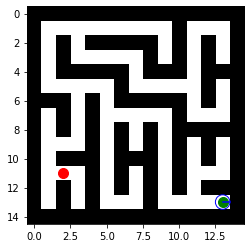

In [11]:
# 迷路を生成
maze_h = 15 # 迷路の縦幅を指定 
maze_w = 15 # 迷路の横幅を指定
maze = np.zeros((maze_h, maze_w)) # 迷路用の配列を作成
maze = create_outer_wall(maze) # 迷路の外壁を生成
maze = create_pillar(maze) # 迷路内にを生成
maze = create_random_obs(maze) # 迷路内の柱から，ランダムに伸びる壁を生成

# スタート地点，ゴール地点を設定
# 左手法の場合，ゴール地点が壁に接していないとゴールできないので，ゴール地点は手動で設定（ここでは，迷路の右下に設定）
start = set_random_start(maze)
goal = [0, 0]; goal[0] = maze_w-2; goal[1] = maze_h-2
 
# 左手法を実行
xs, ys, thetas = left_hand_method(maze, start, goal, max_loop=1000, real_time_animation=False)

<br>

# アニメーション化
左手法と直接的に関係はないので，スキップしてもOK．  
xs, ys, thetasにスタート〜ゴールまでの「座標，角度」が格納してあるので，それを元にアニメーションを作成する．  


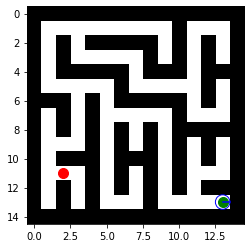

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_aspect("equal")#画像の比率を同じにする

def update(i):
    ax1.cla()
    plot_start_and_goal(ax1, start, goal)
    plot_agent(ax1, xs[i], ys[i], thetas[i])
    ax1.imshow(maze, cmap="binary")
 
# 4. アニメーション化
ani = FuncAnimation(fig, update, interval=100, frames=len(thetas))
HTML(ani.to_jshtml())
#ani.save('left_hand.mp4', writer="ffmpeg") # mp4で保存．これを実行すると処理時間が増加します

<br>

# おまけ：コードをスマートに

```
    if left_state == BLANK:
        circle_robot.theta += 90
        circle_robot.theta = circle_robot.theta%360
        dx = 1*math.cos(math.radians(circle_robot.theta))
        dy = 1*math.sin(math.radians(circle_robot.theta))
        circle_robot.x += int(dx)
        circle_robot.y -= int(dy)
       

    if left_state==WALL and front_state==BLANK:
       dx = 1*math.cos(math.radians(circle_robot.theta))
       dy = 1*math.sin(math.radians(circle_robot.theta))
       circle_robot.x += int(dx)
       circle_robot.y -= int(dy)

    if left_state==WALL and front_state==WALL and right_state==BLANK:
        circle_robot.theta -= 90
        circle_robot.theta = circle_robot.theta%360
        dx = 1*math.cos(math.radians(circle_robot.theta))
        dy = 1*math.sin(math.radians(circle_robot.theta))
        circle_robot.x += int(dx)
        circle_robot.y -= int(dy)

    if left_state==WALL and front_state==WALL and right_state==WALL:
        circle_robot.theta -= 180
        circle_robot.theta = circle_robot.theta%360
        dx = 1*math.cos(math.radians(circle_robot.theta))
        dy = 1*math.sin(math.radians(circle_robot.theta))
        circle_robot.x += int(dx)
        circle_robot.y -= int(dy)
    
```